In [1]:
%matplotlib notebook

import random
import numpy as np

np.random.seed(1000)
random.seed(1000)

import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import math
import datetime

from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as st

import matplotlib.patches as patches
import matplotlib as mpl

import scipy

import shapely.geometry
import shapely.affinity


In [2]:
# c = shapely.geometry.box(1, 2, 3, 4)
# cc = shapely.geometry.box(10, 20, 30, 40)
# rc = shapely.affinity.rotate(c, 0.1)
# print(rc)
# print(c.intersection(rc).area)

In [3]:
room_width = 5 # meters y-axis
room_length = 7 # meters x-axis
tile_width = .2 # meters
desk_width = 1.2 # meters y-axis
desk_length = 1.2 # meters x-axis
fan_x = 0
fan_y = room_width / 2

covid_distance = 0.3 # meters

total_area = room_width * room_length
max_desks_area = ((desk_width + covid_distance) * (desk_length + covid_distance)) 
max_n_desks = total_area / max_desks_area
rotation_degress = [np.pi * d / 180.0 for d in range(0, 360, 30)]
idx2degree = {k: v for k, v in enumerate(rotation_degress)}
# print(idx2degree)
print(max_n_desks)

15.555555555555555


In [4]:
y_n_tiles = int(room_width/tile_width) # across x-axis
x_n_tiles = int(room_length/tile_width) # accross y-axis
total_tiles = y_n_tiles * x_n_tiles

In [5]:
population_size = 20
max_training_iterations = 1000
tournament_selection_size = 5 # tournament size to select parents for crossover
parents_to_keep = -1 # if -1, keep half of the original population to the next generaiton
mutation_rate = 0.6 # if 1, 100% of the genes will have the chance to mutate. 
crossover_type = "single" # can be 'uniform'

training_print_interval =  (max_training_iterations // 10) # prints by this value interval. 
                                                    # can be changed to 1 to max_training_iterations
                                                    # by defualt it prints 10 times only 

In [6]:
nbs = {} # neighbours
cell2coord = {}
for i in range(x_n_tiles):
  for j in range(y_n_tiles):
    cell = f"{i}-{j}"
    cell2coord[cell] = (i*tile_width, j*tile_width)
    if cell not in nbs:
      nbs[cell] = []
    if j + 1 != y_n_tiles:
      nbs[cell].append(f"{i}-{j+1}")
    if j + 1 != y_n_tiles and i+1 != x_n_tiles:
      nbs[cell].append(f"{i+1}-{j+1}")
    if i+1 != x_n_tiles:
      nbs[cell].append(f"{i+1}-{j}")
    if j - 1 >= 0 and i+1 != x_n_tiles:
      nbs[cell].append(f"{i+1}-{j-1}")
    if j - 1 >= 0:
      nbs[cell].append(f"{i}-{j-1}")
    if j - 1 >= 0 and i-1 >= 0:
      nbs[cell].append(f"{i-1}-{j-1}")
    if  i-1 >= 0:
      nbs[cell].append(f"{i-1}-{j}")
    if j + 1 != y_n_tiles and i-1 >= 0:
      nbs[cell].append(f"{i-1}-{j+1}")

In [7]:
idx2tile = {}
idx2coord = {}
tile2idx ={}
idx2nbs = {}
for i, (k, v) in enumerate(nbs.items()):
  idx2tile[i] = k
  tile2idx[k] = i
  idx2coord[i] = cell2coord[k]

for i, (k, v) in enumerate(nbs.items()): 
  idx2nbs[i] = list([tile2idx[x] for x in v])

EMPTY_TILE = 0

In [8]:
# def get_rotated_rect(x1, y1, w, h, a):
#     a_xmax = x1 + h/2
#     a_xmin = x1 - h/2
#     a_ymax = y1 + w/2
#     a_ymin = y1 - w/2
#     r1 = shapely.geometry.box(a_xmin, a_ymin, a_xmax, a_ymax)
#     r1 = shapely.affinity.rotate(r1, a)
#     return r1
    
occopation = np.array([EMPTY_TILE] * len(idx2tile), dtype=np.int32)
rand_places = np.random.randint(low=0, high=len(occopation), size=int(max_n_desks)//2)
occopation[rand_places] = 1
facing = np.random.randint(0, len(idx2degree), size=len(occopation))
# new_coords = []
# for i in np.argwhere(occopation == 1).flatten():
#     x, y = idx2coord[i]
    
# desk_prob = max_desks_area / total_area
# print(desk_prob)
# for i in range(len(occopation)):
#   r = np.random.random()
#   if r <= desk_prob:
#     occopation[i] = 1

<IPython.core.display.Javascript object>


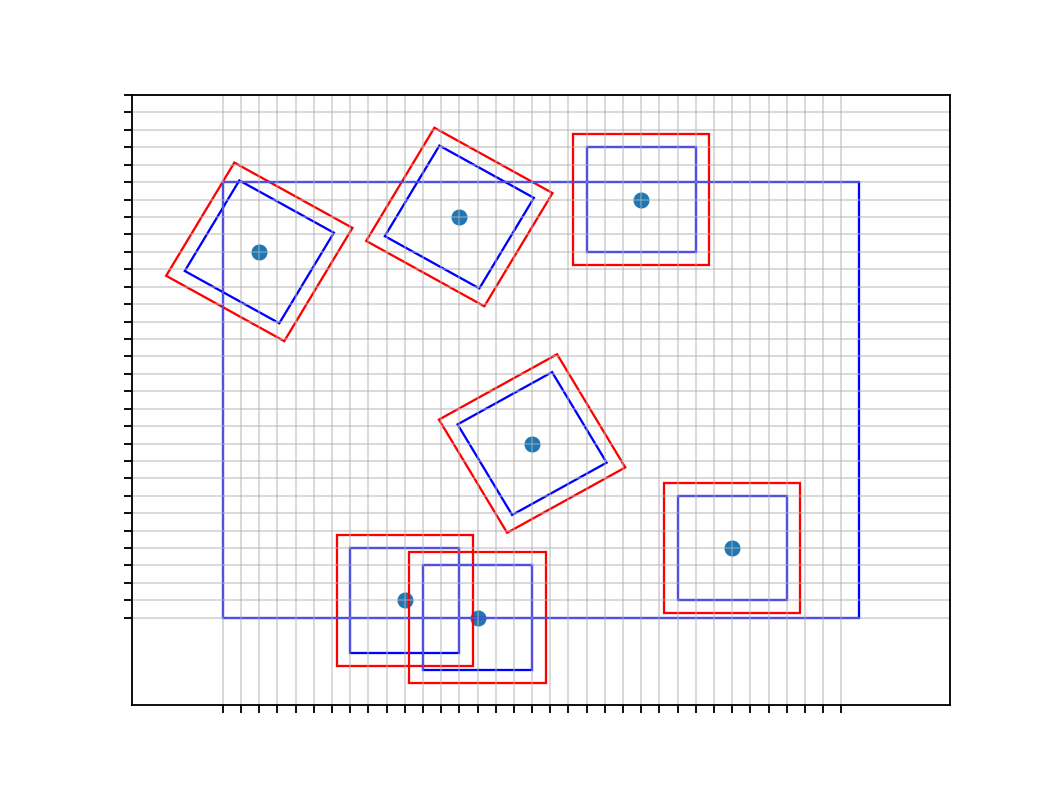

In [9]:
def plot_desks2(occopation):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    # Major ticks every 20, minor ticks every 5
    major_ticks = np.arange(0, room_length, tile_width)
    minor_ticks = np.arange(0, room_length, 1)

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)

    argOnes = np.argwhere(occopation == 1).flatten()
    coords = np.array([cell2coord[idx2tile[x]] for x in argOnes])
    degrees = np.array([idx2degree[facing[x]] for x in argOnes])
    x, y = coords[:, 0], coords[:, 1]
    ax.scatter(x, y)

    for xi, yi, d in zip(x, y, degrees):
        w = (covid_distance + desk_width) / 2
        h = (covid_distance + desk_length) / 2
        rect = patches.Rectangle((xi-h, yi-w), h*2, w*2, linewidth=1, edgecolor='r', facecolor='none')
        t2 = mpl.transforms.Affine2D().rotate_deg_around(xi, yi, d*180/np.pi) + ax.transData
        rect.set_transform(t2)
        # Add the patch to the Axes
        ax.add_patch(rect)
        w = (desk_width) / 2
        h = (desk_length) / 2
        rect = patches.Rectangle((xi-h, yi-w), h*2, w*2, linewidth=1, edgecolor='b', facecolor='none')
        t2 = mpl.transforms.Affine2D().rotate_deg_around(xi, yi, d*180/np.pi) + ax.transData
        rect.set_transform(t2)
        # Add the patch to the Axes
        ax.add_patch(rect)

    rect = patches.Rectangle((0, 0), room_length, room_width, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    # And a corresponding grid
    ax.grid(which='both')

    # Or if you want different settings for the grids:
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

    ax.set_xlim(-1, room_length+1)
    ax.set_ylim(-1, room_width+1)

    plt.setp( ax.get_xticklabels(), visible=False)
    plt.setp( ax.get_yticklabels(), visible=False)
    plt.show()

plot_desks2(occopation)

In [10]:
# def plot_desks(occopation):
#   fig = plt.figure()
#   ax = fig.add_subplot(1, 1, 1)

#   # Major ticks every 20, minor ticks every 5
#   major_ticks = np.arange(0, room_length, tile_width)
#   minor_ticks = np.arange(0, room_length, 1)

#   ax.set_xticks(major_ticks)
#   ax.set_xticks(minor_ticks, minor=True)
#   ax.set_yticks(major_ticks)
#   ax.set_yticks(minor_ticks, minor=True)

#   argOnes = np.argwhere(occopation == 1).flatten()
#   coords = np.array([cell2coord[idx2tile[x]] for x in argOnes])
#   x, y = coords[:, 0], coords[:, 1]
#   ax.scatter(x, y)

#   for xi, yi in zip(x, y):
#     w = (covid_distance + desk_width) / 2
#     h = (covid_distance + desk_length) / 2
#     rect = patches.Rectangle((xi-h, yi-w), h*2, w*2, linewidth=1, edgecolor='r', facecolor='none')
#     # Add the patch to the Axes
#     ax.add_patch(rect)
#     w = (desk_width) / 2
#     h = (desk_length) / 2
#     rect = patches.Rectangle((xi-h, yi-w), h*2, w*2, linewidth=1, edgecolor='b', facecolor='none')
#     # Add the patch to the Axes
#     ax.add_patch(rect)

#   rect = patches.Rectangle((0, 0), room_length, room_width, linewidth=1, edgecolor='b', facecolor='none')
#   ax.add_patch(rect)
#   # And a corresponding grid
#   ax.grid(which='both')

#   # Or if you want different settings for the grids:
#   ax.grid(which='minor', alpha=0.2)
#   ax.grid(which='major', alpha=0.5)
  
#   ax.set_xlim(-1, room_length+1)
#   ax.set_ylim(-1, room_width+1)
  
#   plt.setp( ax.get_xticklabels(), visible=False)
#   plt.setp( ax.get_yticklabels(), visible=False)
#   plt.show()

# plot_desks(occopation)

<IPython.core.display.Javascript object>


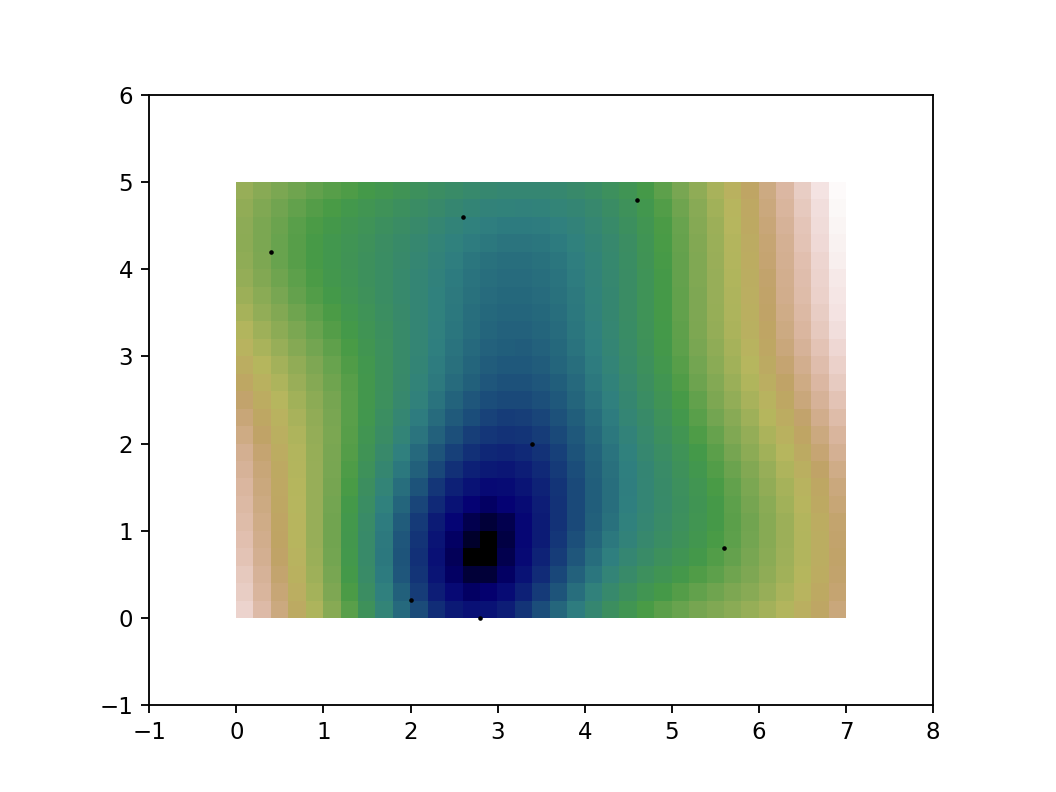

In [11]:
def plot_occopation_densit(occopation):
    argOnes = np.argwhere(occopation == 1).flatten()
    coords = np.array([cell2coord[idx2tile[x]] for x in argOnes])
    x, y = coords[:, 0], coords[:, 1]

    X, Y = np.mgrid[0:room_length:tile_width, 0:room_width:tile_width]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)

    fig, ax = plt.subplots(1,1)
    ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
            extent=[0, room_length, 0, room_width])
    ax.plot(x, y, 'k.', markersize=2)
    ax.set_xlim([-1, room_length+1])
    ax.set_ylim([-1, room_width+1])
    plt.show()

plot_occopation_densit(occopation)

In [12]:
# MST
parent = [0] * 1000
size = [0] * 1000
 
# Utility function to find set of an element v using path compression technique
def find_set(v):
    if (v == parent[v]):
        return v
 
    # Otherwsie find the parent 
    parent[v] = find_set(parent[v])
 
    return parent[v]

# Function to perform union of the sets a and b (Disjoint Set Data Structures)
def union_sets(a, b):
     
    # Find parent of a and b
    a = find_set(a)
    b = find_set(b)
 
    # If parent are different
    if (a != b):
        # Swap Operation
        if (size[a] < size[b]):
            a, b = b, a
        # Update parent of b as a
        parent[b] = a
        size[a] += size[b]
        return 1
    return 0
 
# Function to create a Minimum Cost Spanning tree
def MST(xy, n):
     
    # Stores adjacency list of graph
    v = []
 
    # Traverse each coordinate
    for i in range(n):
        for j in range(i + 1, n):
 
            # Find the Manhattan distance
            p = abs(xy[i][0] -
                    xy[j][0])
 
            p += abs(xy[i][1] -
                     xy[j][1])
 
            # Add the edges
            v.append([p, i, j])
 
    # Sort all the edges
    v = sorted(v)
 
    # Initialize parent[] and size[]
    for i in range(n):
        # print(i)
        parent[i] = i
        size[i] = 1
 
    # Stores the minimum cost
    cost = 0
 
    # Finding the minimum cost
    for x in v:
 
        # Perform the unioun operation
        if (union_sets(x[1], x[2])):
            cost += x[0]
             
    return v , cost

# if __name__ == '__main__':
     
#     # coordinates 
#     tables = [ [ 0, 0 ], [ 2, 2 ],
#                [ 3, 10 ], [ 5, 2 ],
#                [ 7, 0 ] ]
#     adjacency_list , min_cost = MST(tables, len(tables))
#     print(adjacency_list)
#     print(min_cost)

In [13]:
# 2* ((2*(.6 ** .6)) ** .5)

In [14]:

rects = [
    shapely.geometry.box(-10, 0, 0, room_width),
    shapely.geometry.box(0, room_width, room_length, room_width+10),
    shapely.geometry.box(room_length, 0, room_length + 10, room_width),
    shapely.geometry.box(0, -10, room_length, 0),
]

desks ={}


def create_box(x1, y1, w, h, a):
    a_xmax = x1 + h/2 
    a_xmin = x1 - h/2 
    a_ymax = y1 + w/2 
    a_ymin = y1 - w/2 
    r1 = shapely.geometry.box(a_xmin, a_ymin, a_xmax, a_ymax)
    r1 = shapely.affinity.rotate(r1, a)
    return r1


idx2rot_coord= {}


def _calc_wall_collision2(x1, y1, w, h, a):
    a_xmax = x1 + h/2 
    a_xmin = x1 - h/2 
    a_ymax = y1 + w/2 
    a_ymin = y1 - w/2 
    r1 = shapely.geometry.box(a_xmin, a_ymin, a_xmax, a_ymax)
    r1 = shapely.affinity.rotate(r1, a)
    c = 0
    for r in rects:
        op = r1.intersection(r)
        if not op.is_empty:
            c += op.area
    return c


def wall_collision_cost(occopation, faces):
    global idx2coord, desk_width, desk_length, covid_distance, room_width
    w =   desk_width
    h =   desk_length
    cost = 0
    for i, o in enumerate(occopation):
        if o == 1: # has desk on it
            x, y = idx2coord[i] # get the coordinate of the desk 
            dj = idx2degree[faces[j]]
            cost += _calc_wall_collision2(x, y, h, w, dj)
    return -cost

def _overlap_area(x1, x2, y1, y2, h, w):  # returns None if rectangles don't intersect
  a_xmax, b_xmax = x1 + h/2, x2 + h/2
  a_xmin, b_xmin = x1 - h/2, x2 - h/2
  a_ymax, b_ymax = y1 + w/2, y2 + w/2
  a_ymin, b_ymin = y1 - w/2, y2 - w/2
  dx = min(a_xmax, b_xmax) - max(a_xmin, b_xmin)
  dy = min(a_ymax, b_ymax) - max(a_ymin, b_ymin)
  if (dx>=0) and (dy>=0):
      return dx*dy
  return 0

def _dect_collision(x1, x2, y1, y2, w, h, a1, a2):
    a_xmax, b_xmax = x1 + h/2, x2 + h/2
    a_xmin, b_xmin = x1 - h/2, x2 - h/2
    a_ymax, b_ymax = y1 + w/2, y2 + w/2
    a_ymin, b_ymin = y1 - w/2, y2 - w/2
    r1 = shapely.geometry.box(a_xmin, a_ymin, a_xmax, a_ymax)
    r2 = shapely.geometry.box(b_xmin, b_ymin, b_xmax, b_ymax)
    r1 = shapely.affinity.rotate(r1, a1)
    r2 = shapely.affinity.rotate(r2, a2)
    op = r1.intersection(r2)
    if op.is_empty:
        return 0
    else:
        return op.area

def _overlap_area(x1, x2, y1, y2, h, w):  # returns None if rectangles don't intersect
  a_xmax, b_xmax = x1 + h/2, x2 + h/2
  a_xmin, b_xmin = x1 - h/2, x2 - h/2
  a_ymax, b_ymax = y1 + w/2, y2 + w/2
  a_ymin, b_ymin = y1 - w/2, y2 - w/2
  dx = min(a_xmax, b_xmax) - max(a_xmin, b_xmin)
  dy = min(a_ymax, b_ymax) - max(a_ymin, b_ymin)
  if (dx>=0) and (dy>=0):
      return dx*dy
  return 0

def distance(x1, x2, y1, y2):
    return ((x1 - x2)**2 + (y1 - y2)**2) ** .5


def desk_collision_cost(occopation, facing):
  global idx2coord, desk_width, desk_length, covid_distance, room_width
  w =   desk_width + covid_distance
  h =   desk_length + covid_distance
  cost = 0
  desk_locs = np.argwhere(occopation > 0).flatten()
  # print(desk_locs)
  for ki, i in enumerate(desk_locs):
    for kj, j in enumerate(desk_locs[ki:]):
      if i != j:
        x1, y1 = idx2coord[i]
        x2, y2 = idx2coord[j]
        if distance(x1, x2, y1, y2) < 2.426:
            dj = idx2degree[facing[j]]
            di = idx2degree[facing[i]]
            if i not in desks:
                b1 = create_box(x1, y1, h, w, di)
                desks[i] = b1
            else: 
                b1 = desks[i]
            
            if j not in desks:
                b2 = create_box(x2, y2, h, w, dj)
                desks[j] = b2
            else: 
                b2 = desks[j]
                
            a = b1.intersection(b2)
            if not a.is_empty:
                cost += a.area
  return -cost

# print(wall_collision_cost(occopation))

def _calc_airflow(x, y):
  return 1/np.sqrt(np.square(fan_x-x) + np.square(fan_y-y))

def _calc_density(occopation, facing):
  # argOnes = np.argwhere(occopation == 1).flatten()
  # coords = np.array([cell2coord[idx2tile[x]] for x in argOnes])
  # x, y = coords[:, 0], coords[:, 1]

  # X, Y = np.mgrid[0:room_length:tile_width, 0:room_width:tile_width]
  # positions = np.vstack([X.ravel(), Y.ravel()])
  # values = np.vstack([x, y])
  # kernel = st.gaussian_kde(values)
  # Z = np.reshape(kernel(positions).T, X.shape)
  # # Z = np.rot90(Z)
  # total_density = 0
  # for i in range(x_n_tiles):
  #   for j in range(y_n_tiles):
  #     k = f'{i}-{j}'
  #     xi, yi = cell2coord[k]
  #     flow = _calc_airflow(xi, yi)
  #     z = Z[i, j]
  #     total_density += (flow/z)
  return 0 #total_density

# print(_calc_density(occopation))

def air_flow_cost(occopation, facing):
  desk_locs = np.argwhere(occopation > 0).flatten()
  coords = []
  for l in desk_locs:
    coords.append([idx2coord[l][0], idx2coord[l][0]])
  coords = np.stack(coords)
  d = np.sum(np.subtract(coords, [fan_x, fan_y])**2)**.5

  return -d

def average_distance(occopation, facing):
    desk_locs = np.argwhere(occopation > 0).flatten()
    coords = []
    for l in desk_locs:
        coords.append([idx2coord[l][0], idx2coord[l][0]])
    coords = np.stack(coords)
    dist = scipy.spatial.distance.pdist(coords)
    return dist.sum() / (len(dist) - len(desk_locs))
  

def turns_cost(occopation, facing):
  # implement a cost function for number of turns
  # basically, this will maximizes the average of length of straight lines
  return 0  

def networking_cost(occopation, facing):
  desk_locs = np.argwhere(occopation > 0).flatten()
  coords = []
  for l in desk_locs:
    coords.append([idx2coord[l][0], idx2coord[l][0]])
  # print(coords)
  adjacency_list , min_cost = MST(coords, len(coords))
  return -min_cost

def desk_amount_cost(occopation, facing):
#   x = sum(occopation)
  return sum(occopation) # max_n_desks * np.exp(-(x - max_n_desks)**2)

def desk_max_amount_cost(occopation, facing):
  return max_n_desks - sum(occopation)

<IPython.core.display.Javascript object>


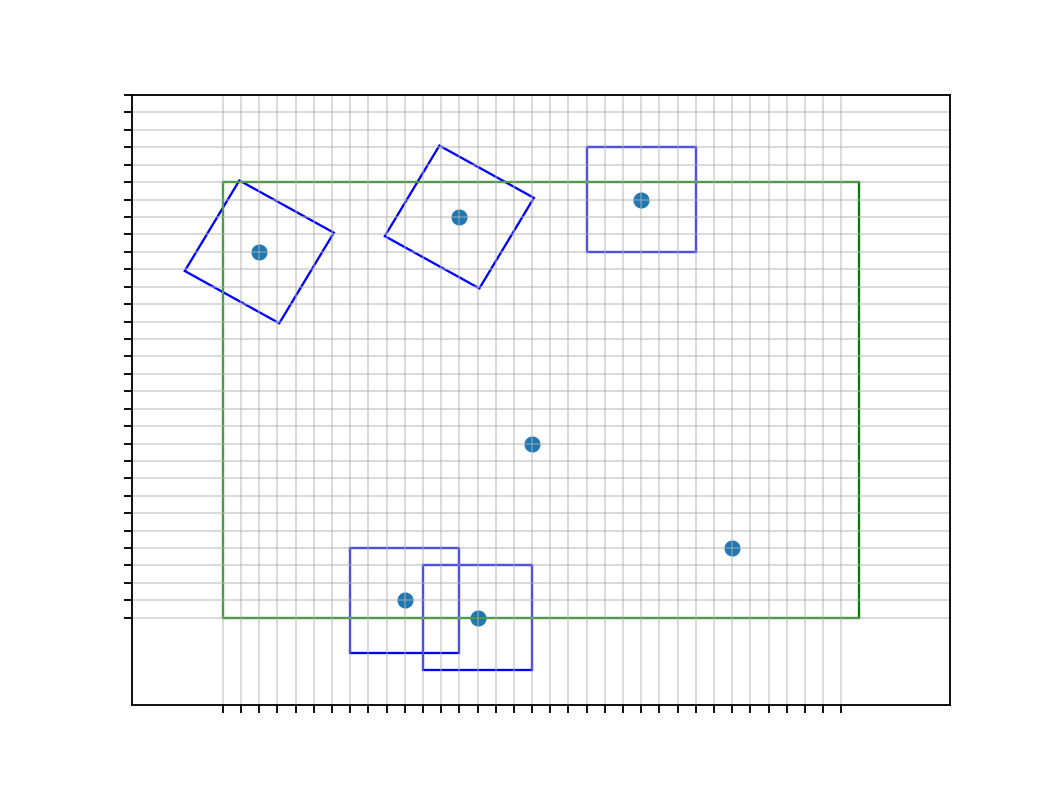

In [15]:
def plot_wall_touched_desks(occopation):
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)

  # Major ticks every 20, minor ticks every 5
  major_ticks = np.arange(0, room_length, tile_width)
  minor_ticks = np.arange(0, room_length, 1)

  ax.set_xticks(major_ticks)
  ax.set_xticks(minor_ticks, minor=True)
  ax.set_yticks(major_ticks)
  ax.set_yticks(minor_ticks, minor=True)

  argOnes = np.argwhere(occopation == 1).flatten()
  coords = np.array([cell2coord[idx2tile[x]] for x in argOnes])
  x, y = coords[:, 0], coords[:, 1]
  ax.scatter(x, y)
  degrees = np.array([idx2degree[facing[x]] for x in argOnes])

  for xi, yi, d in zip(x, y, degrees):
    w = (desk_width) / 2
    h = (desk_length) / 2
    cost = _calc_wall_collision2(xi, yi, h*2, w*2, d)
    if cost > 0:
      rect = patches.Rectangle((xi-h, yi-w), h*2, w*2, linewidth=1, edgecolor='b', facecolor='none')
      t2 = mpl.transforms.Affine2D().rotate_deg_around(xi, yi, d*180/np.pi) + ax.transData
      rect.set_transform(t2)
      # Add the patch to the Axes
      ax.add_patch(rect)
    
  rect = patches.Rectangle((0, 0), room_length, room_width, linewidth=1, edgecolor='g', facecolor='none')
  ax.add_patch(rect)
  # And a corresponding grid
  ax.grid(which='both')

  # Or if you want different settings for the grids:
  ax.grid(which='minor', alpha=0.2)
  ax.grid(which='major', alpha=0.5)
  
  ax.set_xlim(-1, room_length+1)
  ax.set_ylim(-1, room_width+1)
  

  plt.setp( ax.get_xticklabels(), visible=False)
  plt.setp( ax.get_yticklabels(), visible=False)
  plt.show()

plot_wall_touched_desks(occopation)

<IPython.core.display.Javascript object>


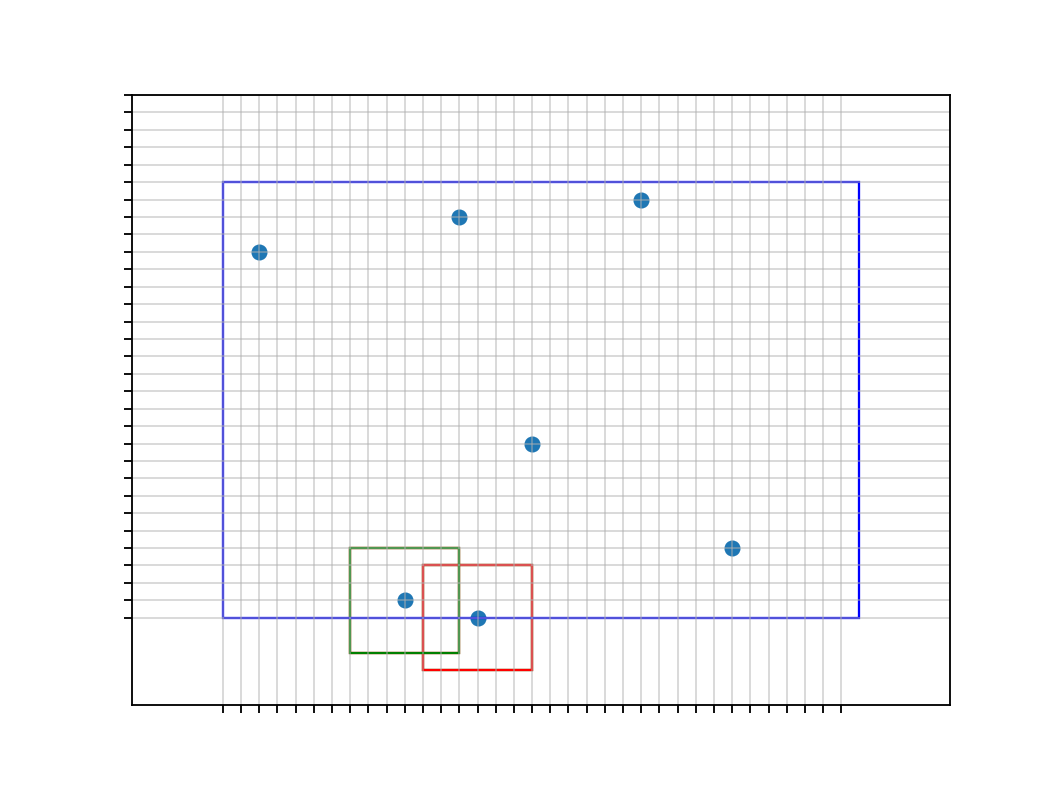

In [16]:
def plot_collided_desks(occopation):
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)

  # Major ticks every 20, minor ticks every 5
  major_ticks = np.arange(0, room_length, tile_width)
  minor_ticks = np.arange(0, room_length, 1)

  ax.set_xticks(major_ticks)
  ax.set_xticks(minor_ticks, minor=True)
  ax.set_yticks(major_ticks)
  ax.set_yticks(minor_ticks, minor=True)

  argOnes = np.argwhere(occopation == 1).flatten()
  coords = np.array([cell2coord[idx2tile[x]] for x in argOnes])
  x, y = coords[:, 0], coords[:, 1]
  ax.scatter(x, y)
  w = (desk_width) / 2
  h = (desk_length) / 2
  for i in argOnes:
    for j in argOnes:
      if i != j:
        x1, y1 = idx2coord[i]
        x2, y2 = idx2coord[j]
        a = _overlap_area(x1, x2, y1, y2, h*2, w*2)
        if a > 0:
          rect = patches.Rectangle((x1-h, y1-w), h*2, w*2, linewidth=1, edgecolor='r', facecolor='none')
          ax.add_patch(rect)
          rect = patches.Rectangle((x2-h, y2-w), h*2, w*2, linewidth=1, edgecolor='g', facecolor='none')
          ax.add_patch(rect)

  # for xi, yi in zip(x, y):
  #   w = (desk_width) / 2
  #   h = (desk_length) / 2
  #   cost = _overlap_area(xi, yi, h*2, w*2)
  #   if cost > 0:
  #     rect = patches.Rectangle((xi-h, yi-w), h*2, w*2, linewidth=1, edgecolor='r', facecolor='none')
  #     ax.add_patch(rect)
    
  rect = patches.Rectangle((0, 0), room_length, room_width, linewidth=1, edgecolor='b', facecolor='none')
  ax.add_patch(rect)
  # And a corresponding grid
  ax.grid(which='both')

  # Or if you want different settings for the grids:
  ax.grid(which='minor', alpha=0.2)
  ax.grid(which='major', alpha=0.5)
  ax.set_xlim(-1, room_length+1)
  ax.set_ylim(-1, room_width+1)
  

  plt.setp( ax.get_xticklabels(), visible=False)
  plt.setp( ax.get_yticklabels(), visible=False)
  plt.show()

plot_collided_desks(occopation)

In [17]:
# desk_amount_cost(occopation)

In [18]:
objective_functions = {
#     "desk_amount": desk_amount_cost,
#     "desk_max_amount": desk_max_amount_cost,
#     "dispersion": average_distance,
    "networking": networking_cost,
#     "air_flow": air_flow_cost,
    "desk_collision": desk_collision_cost,
    "wall_collision": wall_collision_cost
}

def calc_pop_objectives(pops, faces):
    global objective_functions
    objective_scores = []
    for i in range(len(pops)):
        occopation = pops[i]
        face = faces[i]
        objs = []
        for key in objective_functions.keys():
            obj_fun = objective_functions[key]
            breed_start_time = datetime.datetime.now()
            result = obj_fun(occopation, face)
            t = (datetime.datetime.now() - breed_start_time).total_seconds()
#             print(key, t)
            objs.append(result)
        objective_scores.append(objs)
    return np.array(objective_scores)


In [19]:
# calc_pop_objectives(init_pop, face)

In [20]:
def calculate_crowding(scores):

    population_size = len(scores[:, 0])
    number_of_scores = len(scores[0, :])

    # create crowding matrix of population (row) and score (column)
    crowding_matrix = np.zeros((population_size, number_of_scores))

    # normalise scores (ptp is max-min)
    normed_scores = (scores - scores.min(0)) / scores.ptp(0)

    # calculate crowding distance for each score in turn
    for col in range(number_of_scores):
        crowding = np.zeros(population_size)

        # end points have maximum crowding
        crowding[0] = 1
        crowding[population_size - 1] = 1

        # Sort each score (to calculate crowding between adjacent scores)
        sorted_scores = np.sort(normed_scores[:, col])

        sorted_scores_index = np.argsort(
            normed_scores[:, col])

        # Calculate crowding distance for each individual
        crowding[1:population_size - 1] = \
            (sorted_scores[2:population_size] -
             sorted_scores[0:population_size - 2])

        # resort to orginal order (two steps)
        re_sort_order = np.argsort(sorted_scores_index)
        sorted_crowding = crowding[re_sort_order]

        # Record crowding distances
        crowding_matrix[:, col] = sorted_crowding

    # Sum crowding distances of each score
    crowding_distances = np.sum(crowding_matrix, axis=1)

    return crowding_distances

In [21]:
def reduce_by_crowding(scores, number_to_select):
   
    population_ids = np.arange(scores.shape[0])

    crowding_distances = calculate_crowding(scores)

    picked_population_ids = np.zeros((number_to_select))

    picked_scores = np.zeros((number_to_select, len(scores[0, :])))

    for i in range(number_to_select):

        population_size = population_ids.shape[0]

        fighter1ID = rn.randint(0, population_size - 1)

        fighter2ID = rn.randint(0, population_size - 1)

        # If fighter # 1 is better
        if crowding_distances[fighter1ID] >= crowding_distances[fighter2ID]:

            fid = fighter1ID
            if crowding_distances[fighter1ID] == crowding_distances[fighter2ID]:
                fid = np.random.choice([fighter1ID, fighter2ID])
            # add solution to picked solutions array
            picked_population_ids[i] = population_ids[fid]

            # Add score to picked scores array
            picked_scores[i, :] = scores[fid, :]

            # remove selected solution from available solutions
            population_ids = np.delete(population_ids, (fid), axis=0)

            scores = np.delete(scores, (fid), axis=0)

            crowding_distances = np.delete(crowding_distances, (fid), axis=0)
        else:
            picked_population_ids[i] = population_ids[fighter2ID]

            picked_scores[i, :] = scores[fighter2ID, :]

            population_ids = np.delete(population_ids, (fighter2ID), axis=0)

            scores = np.delete(scores, (fighter2ID), axis=0)

            crowding_distances = np.delete(
                crowding_distances, (fighter2ID), axis=0)

    # Convert to integer 
    picked_population_ids = np.asarray(picked_population_ids, dtype=int)
    
    
    return (picked_population_ids)

In [22]:
def identify_pareto(scores, population_ids):
    """
    Identifies a single Pareto front, and returns the population IDs of
    the selected solutions.
    """
    population_size = scores.shape[0]
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by out 'j' point
            if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]): # making it
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front], pareto_front

In [23]:
def build_pareto_population(population, scores, minimum_population_size, maximum_population_size):
    """
    As necessary repeats Pareto front selection to build a population within
    defined size limits. Will reduce a Pareto front by applying crowding 
    selection as necessary.    
    """
    unselected_population_ids = np.arange(population.shape[0], dtype=np.int)
    all_population_ids = np.arange(population.shape[0], dtype=np.int)
#     print(scores.shape)
    pareto_front = []
    pareto_front_labels = {}
    pareto_label_counter = 0
    while len(pareto_front) < minimum_population_size:
        temp_pareto_front, _pareto_front = identify_pareto(scores[unselected_population_ids, :], unselected_population_ids)
        pareto_front_labels[pareto_label_counter] = temp_pareto_front
        pareto_label_counter += 1
        # Check size of total parteo front. 
        # If larger than maximum size reduce new pareto front by crowding
        combined_pareto_size = len(pareto_front) + len(temp_pareto_front)
        if combined_pareto_size > maximum_population_size:
            number_to_select = combined_pareto_size - maximum_population_size
            selected_individuals = (reduce_by_crowding(
                    scores[temp_pareto_front], number_to_select))
            temp_pareto_front = temp_pareto_front[selected_individuals]
        
        # Add latest pareto front to full Pareto front
        pareto_front = np.hstack((pareto_front, temp_pareto_front))
        
        
        # Update unselected population ID by using sets to find IDs in all
        # ids that are not in the selected front
        unselected_set = set(all_population_ids) - set(pareto_front)
        unselected_population_ids = np.array(list(unselected_set))

    _population = population[pareto_front.astype(int)]
    return _population, population, pareto_front_labels

In [24]:
def single_point_crossover(parent1, parent2, facing1, facing2):
    child = parent1.copy() #start with oparent 1 gene, and updated it with parent 2 later
    cfacing = facing1.copy()
    
    argOnes = np.argwhere(occopation > 0).flatten()
    
    child[argOnes[len(argOnes)//2:]] = parent2[argOnes[len(argOnes)//2:]].copy()
    cfacing[argOnes[len(argOnes)//2:]] = facing2[argOnes[len(argOnes)//2:]].copy()

    return child, cfacing


def single_mutuate(pop, face, mutuate_rate, face_mutute_rate=0.2):
    for i in range(len(pop)):
        r = np.random.uniform()
        if r < mutuate_rate:
            r1, r2 = np.random.randint(low=0, high=len(pop[0]), size=2)
            pop[i][r1], pop[i][r2] = pop[i][r2], pop[i][r1]
            face[i][r1], face[i][r2] = face[i][r2], face[i][r1]
        
#         r = np.random.uniform()
#         if r < face_mutute_rate:
#             r1 = np.random.randint(low=0, high=len(idx2degree))
#             face[i] = r1
    

    return pop, face

In [25]:
def breed(crossover_function, pop, face, to_size, k = 5, n_parent=-1):

    childeren = []
    cfacings = []
    
    if n_parent  <= -1:
        n_parent = len(pop) // 2 # set how many of the old parents are needed to half of the pop_size
        
    for i in range(n_parent):
        childeren.append(pop[i]) #copy the top parents to the list
        cfacings.append(face[i])
        
    while len(childeren) < to_size:
        k_selection1 = np.random.choice(len(pop), size=k, replace=True) # tournament 1 to select parent 1
        best1 = k_selection1.min()
        parent1 = pop[best1]
        facing1 = face[best1]

        k_selection2 = np.random.choice(len(pop), size=k, replace=True)  # tournament 2 to select parent 2
        best2 = k_selection2.min()
        parent2 = pop[best2]
        facing2 = face[best2]
        
        child, cface  = crossover_function(parent1, parent2, facing1, facing2)
            
        childeren.append(child)
        cfacings.append(cface)

    return np.stack(childeren), np.stack(cfacings)
        

In [26]:
init_pop = np.zeros((population_size, len(tile2idx)), dtype=np.int32)
face = np.zeros((population_size, len(tile2idx)), dtype=np.int32)
for i in range(population_size):
    oc = []
    fg = []
    for j in range(int(max_n_desks)):
        c = 1
        while c > 0:
            r = np.random.randint(low=0, high=len(occopation), size=1)[0]
            ra = np.random.randint(low=0, high=len(idx2degree), size=1)[0]
            rx, ry = idx2coord[r]
            w =   desk_width
            h =   desk_length
            c = _calc_wall_collision2(rx, ry, w, h, ra)
        oc.append(r)
        fg.append(rx)

    occopation = np.array([EMPTY_TILE] * len(idx2tile), dtype=np.int32)
    rand_places = np.array(oc)
    occopation[rand_places] = 1
    init_pop[i] = occopation
    
    faces = np.random.randint(low=0, high=len(idx2degree), size=len(occopation))
    faces[rand_places] = np.array(fg)
    face[i] = faces



In [27]:
# print(face.shape)
scores = calc_pop_objectives(init_pop, face)

In [28]:
scores = calc_pop_objectives(init_pop, face)
print("Initial mean scores: ", [np.round(x, 2) for x in np.mean(scores, axis=0)])
if crossover_type == "single":
    crossover_function = single_point_crossover
else:
    crossover_function = uniform_crossover

mutation_function = single_mutuate
    
    
pop = init_pop.copy()
bests = []
means = []
epochs = max_training_iterations
time_taken = {"breed": [], "mutaiton": [], "objective": [], "pareto": []}

start_time = datetime.datetime.now() # training started time
total_epochs_taken = 0
for i in range(epochs):
    
    breed_start_time = datetime.datetime.now()
    pop, face = breed(crossover_function, pop, face, len(init_pop), k = tournament_selection_size, n_parent=parents_to_keep)
    time_taken["breed"].append((datetime.datetime.now() - breed_start_time).total_seconds())
    
    mutation_start_time = datetime.datetime.now()
    pop, face = mutation_function(pop, face, (mutation_rate * (max_training_iterations - i) / max_training_iterations))
    time_taken["mutaiton"].append((datetime.datetime.now() - mutation_start_time).total_seconds())
#     print(face[0])
    objective_start_time = datetime.datetime.now()
    scores = calc_pop_objectives(pop, face)
    time_taken["objective"].append((datetime.datetime.now() - objective_start_time).total_seconds())
    
    pareto_start_time = datetime.datetime.now()
    # pop = selected popuplation, prev_pop = unsorted population
    pop, prev_pop, pareto_front_labels = build_pareto_population(pop, scores, len(pop) // 2, len(pop))
    time_taken["pareto"].append((datetime.datetime.now() - pareto_start_time).total_seconds())

    mean = np.mean(scores, axis=0)
    means.append(mean)
    
    if i % training_print_interval == 0 and i > 0: 
        line = [np.round(x, 3) for x in np.mean(scores, axis=0)]
        print({name: line[i] for i, (name,v) in enumerate(objective_functions.items())})

    total_epochs_taken += 1
        
elapsed = (datetime.datetime.now() - start_time).total_seconds() # training ended time
means = np.stack(means)
print()
print("Total Time taken: {0:.4f} seconds".format(elapsed))
print("Time taken per episod: {0:.4f} seconds".format(elapsed / total_epochs_taken))
print("Breed Time taken per episod: {0:.4f} seconds".format(np.mean(time_taken["breed"])))
print("mutaiton Time taken per episod: {0:.4f} seconds".format(np.mean(time_taken["mutaiton"])))
print("objective calculation Time taken per episod: {0:.4f} seconds".format(np.mean(time_taken["objective"])))
print("pareto sorting Time taken per episod: {0:.4f} seconds".format(np.mean(time_taken["pareto"])))

Initial mean scores:  [-9.86, -17.13, -0.0]
{'networking': -9.36, 'desk_collision': -10.435, 'wall_collision': -0.216}
{'networking': -9.72, 'desk_collision': -8.311, 'wall_collision': -0.12}
{'networking': -9.48, 'desk_collision': -8.979, 'wall_collision': -0.144}
{'networking': -10.1, 'desk_collision': -8.283, 'wall_collision': -0.182}
{'networking': -10.36, 'desk_collision': -7.869, 'wall_collision': -0.281}
{'networking': -9.88, 'desk_collision': -8.065, 'wall_collision': -0.052}
{'networking': -10.1, 'desk_collision': -7.772, 'wall_collision': -0.072}
{'networking': -10.0, 'desk_collision': -7.029, 'wall_collision': -0.168}
{'networking': -10.26, 'desk_collision': -6.973, 'wall_collision': -0.24}

Total Time taken: 282.0175 seconds
Time taken per episod: 0.2820 seconds
Breed Time taken per episod: 0.0012 seconds
mutaiton Time taken per episod: 0.0003 seconds
objective calculation Time taken per episod: 0.2792 seconds
pareto sorting Time taken per episod: 0.0013 seconds


<IPython.core.display.Javascript object>


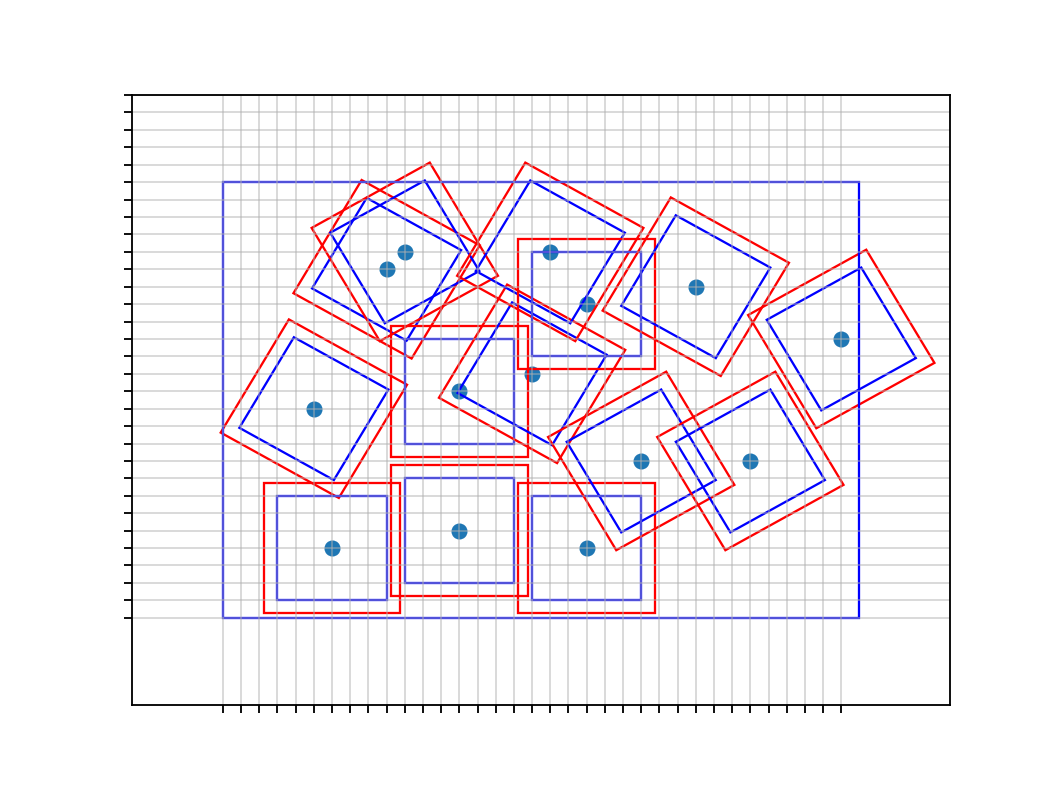

In [29]:
plot_desks2(pop[0])

<IPython.core.display.Javascript object>


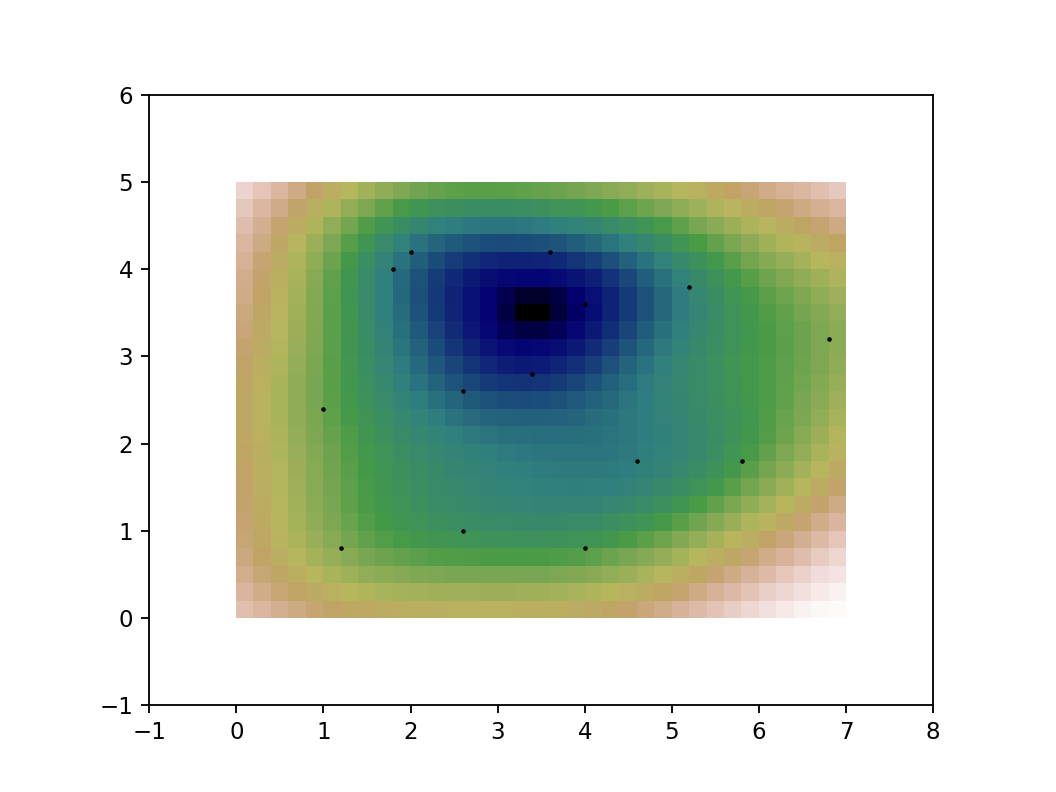

In [30]:
plot_occopation_densit(pop[0])